## WCZYTANIE DANYCH

In [1]:
import numpy as np
import json

import tmtoolkit as tm
from nltk.corpus import opinion_lexicon
import nltk

import pandas as pd

In [2]:
def load_json(filename):
    with open(filename, 'r') as f:
        return json.load(f)

def load_texts(file_name):
    with open(file_name, "r") as file:
        content = file.read()
        texts = content.split("---\n")
        texts = [s.strip() for s in texts if s.strip()]

    return texts

In [3]:
members_of_congress_wiki_pages_names = load_json("members_of_congress_wiki_pages.json")

In [4]:
republicans_texts = load_texts('republicans.txt')
democrats_texts = load_texts('democrats.txt')

In [5]:
neg = set(opinion_lexicon.negative())
pos = set(opinion_lexicon.positive())

In [6]:
def get_words_summary(texts):
    corp = tm.corpus.Corpus(dict(zip(range(len(texts)), texts)), language = "en", load_features=[])
    tm.corpus.remove_punctuation(corp)
    tm.corpus.filter_clean_tokens(corp)
    tm.corpus.to_lowercase(corp)

    df = tm.corpus.tokens_table(corp)
    sent = pd.DataFrame([(tok in pos, tok in neg) for tok in df["token"]], columns=["pos", "neg"])

    df = pd.concat([df, sent], axis = 1)

    return df

In [7]:
def get_article_summary(df):
    df_count = df.groupby("doc")[["pos","neg"]].sum()
    df_count['len'] = np.array([len(df[df['doc'] == i]) for i in set(df['doc'])])
    df_count.loc[:, 'pos_frac'] = df_count['pos']/df_count['len']
    df_count.loc[:, 'neg_frac'] = df_count['neg']/df_count['len']
    df_count.loc[:, 'ratio'] = np.where(df_count['neg_frac'] != 0, df_count['pos_frac'] / df_count['neg_frac'], 0)
    df_count.loc[:, 'ratio'] = np.where(df_count['neg_frac'] != 0, df_count['pos_frac'] / df_count['neg_frac'], 0)

    return df_count


In [8]:
df_rep = get_words_summary(republicans_texts)
df_dem = get_words_summary(democrats_texts)

In [9]:
df_rep_count= get_article_summary(df_rep)
df_dem_count= get_article_summary(df_dem)

In [10]:
df_rep_count

,pos,neg,len,pos_frac,neg_frac,ratio
doc,,,,,,
0,25,22,801,0.031211,0.027466,1.136364
1,45,44,1322,0.034039,0.033283,1.022727
2,46,25,1110,0.041441,0.022523,1.840000
3,46,55,1093,0.042086,0.050320,0.836364
4,16,15,618,0.025890,0.024272,1.066667
...,...,...,...,...,...,...
150,20,9,668,0.029940,0.013473,2.222222
151,10,2,308,0.032468,0.006494,5.000000
152,15,27,838,0.017900,0.032220,0.555556


In [11]:
df_dem_count


,pos,neg,len,pos_frac,neg_frac,ratio
doc,,,,,,
0,17,3,360,0.047222,0.008333,5.666667
1,25,5,561,0.044563,0.008913,5.000000
2,14,12,558,0.025090,0.021505,1.166667
3,33,32,1069,0.030870,0.029935,1.031250
4,30,30,789,0.038023,0.038023,1.000000
...,...,...,...,...,...,...
155,13,5,351,0.037037,0.014245,2.600000
156,59,54,1314,0.044901,0.041096,1.092593
157,20,10,471,0.042463,0.021231,2.000000


## WYKRESY

In [12]:
import matplotlib.pyplot as plt

In [13]:
def plot_bar(categories, dem_values, rep_values, y_label, x_label):

    bar_width = 0.4

    x = range(len(categories))
    x2 = [i + bar_width for i in x]

    plt.bar(x, dem_values, width=bar_width, label="Demokraci", color="blue")
    plt.bar(x2, rep_values, width=bar_width, label="Republikanie", color="red")

    plt.xlabel(x_label)
    plt.ylabel(y_label)

    plt.xticks([i + bar_width / 2 for i in x], categories)

    for i, v in enumerate(dem_values):
        plt.text(x[i], 0.8*v, f'{v:.3f}', ha='center', fontsize=12, color="white")

    for i, v in enumerate(rep_values):
        plt.text(x2[i], 0.8*v, f'{v:.3f}', ha='center', fontsize=12, color="white")

    plt.legend()
    plt.show()

In [14]:
def plot_hist(dem, rep, x_label, bins):
    plt.figure(figsize=(10, 6))

    bins = np.histogram(np.hstack((dem,rep)), bins=bins)[1]
    plt.hist(dem, bins=bins, alpha=0.8, label='Demokraci', color='blue')
    plt.hist(rep, bins=bins, alpha=0.8, label='Republikanie', color='red')

    plt.xlabel(x_label)
    plt.ylabel('Liczba zliczen')
    # plt.title('Histogram wartości pozytywnych i negatywnych')
    plt.legend(loc='upper right')

    plt.show()

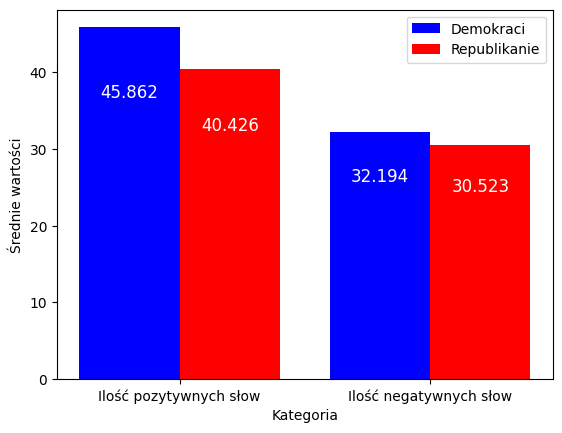

In [15]:
dem_pos_avg = df_dem_count["pos"].mean()
dem_neg_avg = df_dem_count["neg"].mean()
rep_pos_avg = df_rep_count["pos"].mean()
rep_neg_avg = df_rep_count["neg"].mean()


dem = [dem_pos_avg, dem_neg_avg]
rep = [rep_pos_avg, rep_neg_avg]
categories = ["Ilość pozytywnych słow", "Ilość negatywnych słow"]

plot_bar(
    categories=categories,
    dem_values=dem,
    rep_values=rep,
    x_label="Kategoria",
    y_label="Średnie wartości",
)


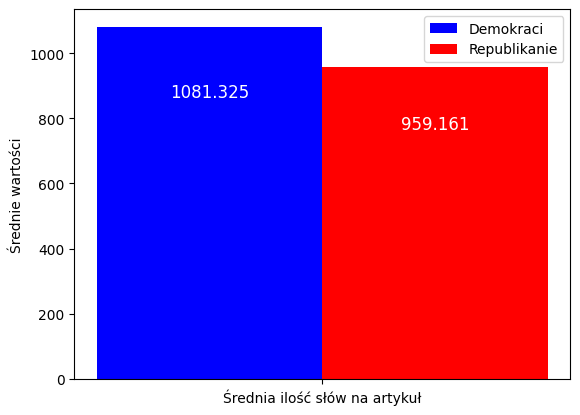

In [16]:
dem_len = np.array([len(df_dem[df_dem['doc'] == i]) for i in set(df_dem['doc'])]).mean()
rep_len = np.array([len(df_rep[df_rep['doc'] == i]) for i in set(df_rep['doc'])]).mean()

categories = ['Średnia ilość słów na artykuł']
plot_bar(categories=categories, dem_values=[dem_len], rep_values=[rep_len], x_label='', y_label='Średnie wartości')


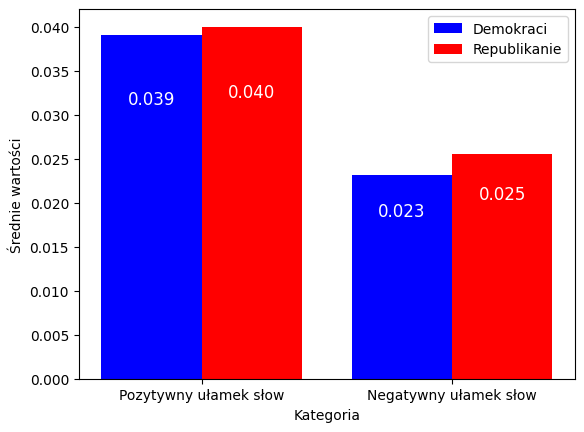

In [17]:
dem_pos_avg = df_dem_count['pos_frac'].mean()
dem_neg_avg = df_dem_count['neg_frac'].mean()
rep_pos_avg = df_rep_count['pos_frac'].mean()
rep_neg_avg = df_rep_count['neg_frac'].mean()


dem = [dem_pos_avg, dem_neg_avg]
rep = [rep_pos_avg, rep_neg_avg]
categories = ['Pozytywny ułamek słow', 'Negatywny ułamek słow']

plot_bar(
    categories=categories,
    dem_values=dem,
    rep_values=rep,
    x_label="Kategoria",
    y_label="Średnie wartości",
)


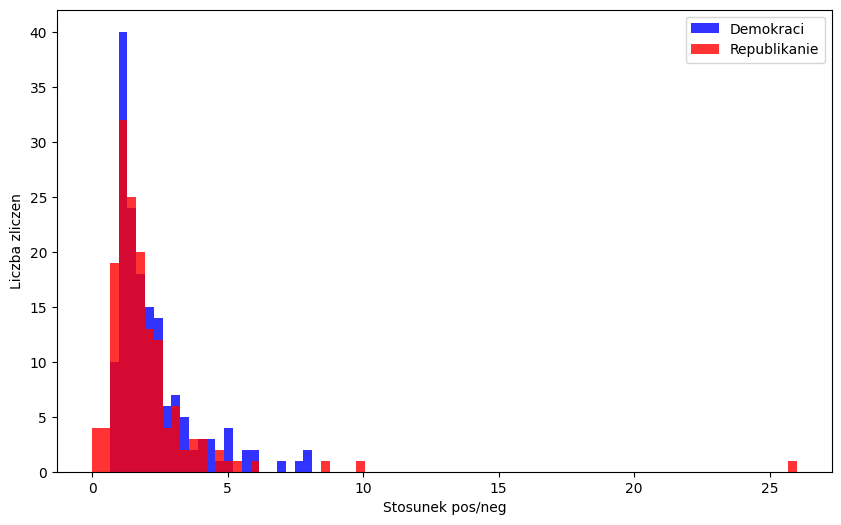

In [18]:
plot_hist(df_dem_count['ratio'], df_rep_count['ratio'], x_label='Stosunek pos/neg', bins=80)

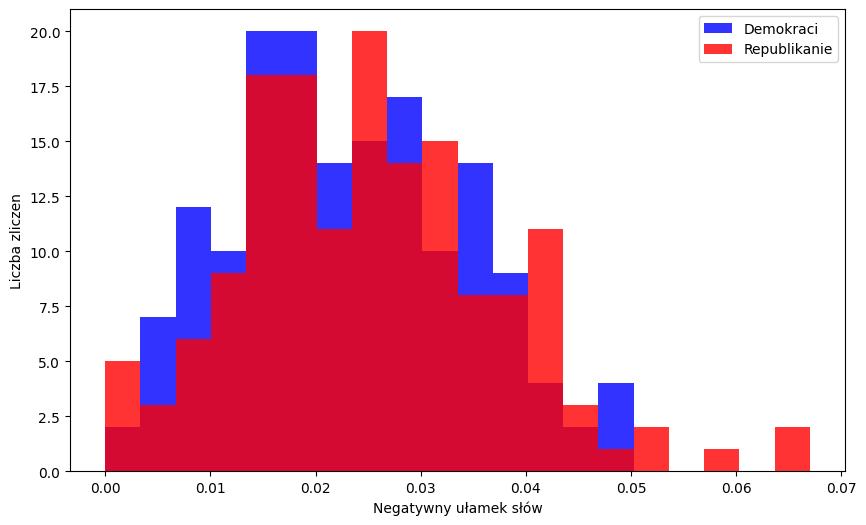

In [19]:
plot_hist(df_dem_count['neg_frac'], df_rep_count['neg_frac'], x_label='Negatywny ułamek słów', bins=20)

# SIA

In [20]:
from nltk.sentiment import SentimentIntensityAnalyzer

In [21]:
# nltk.download('vader_lexicon')

In [22]:
sia = SentimentIntensityAnalyzer()

In [23]:
def sia_sent(texts):
    sents = []

    for text in texts:
        sentiment = sia.polarity_scores(text)
        sents.append(sentiment)

    df = pd.DataFrame(sents)
    df.loc[:, 'ratio'] = np.where(df['neg'] != 0, df['pos'] / df['neg'], 0)

    return df

In [24]:
df_dem2 = sia_sent(democrats_texts)
df_rep2 = sia_sent(republicans_texts)

In [25]:
df_dem2

,neg,neu,pos,compound,ratio
0,0.031,0.893,0.076,0.9738,2.451613
1,0.020,0.892,0.088,0.9947,4.400000
2,0.027,0.945,0.028,0.2382,1.037037
3,0.064,0.880,0.056,-0.9738,0.875000
4,0.060,0.847,0.092,0.9908,1.533333
...,...,...,...,...,...
155,0.023,0.901,0.076,0.9808,3.304348
156,0.073,0.846,0.080,0.9237,1.095890
157,0.039,0.866,0.095,0.9933,2.435897
158,0.078,0.857,0.065,-0.9836,0.833333


In [26]:
df_rep2

,neg,neu,pos,compound,ratio
0,0.053,0.875,0.071,0.9623,1.339623
1,0.067,0.852,0.081,0.9661,1.208955
2,0.030,0.896,0.074,0.9969,2.466667
3,0.072,0.836,0.092,0.9874,1.277778
4,0.025,0.892,0.083,0.9959,3.320000
...,...,...,...,...,...
150,0.039,0.885,0.076,0.9921,1.948718
151,0.013,0.913,0.074,0.9806,5.692308
152,0.039,0.907,0.054,0.9766,1.384615
153,0.055,0.874,0.071,0.9855,1.290909


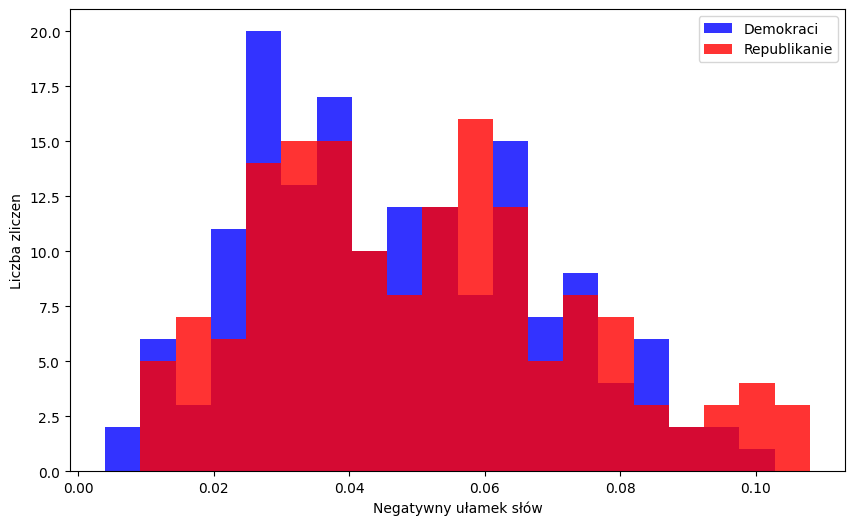

In [27]:
plot_hist(df_dem2['neg'], df_rep2['neg'], 'Negatywny ułamek słów', 20)

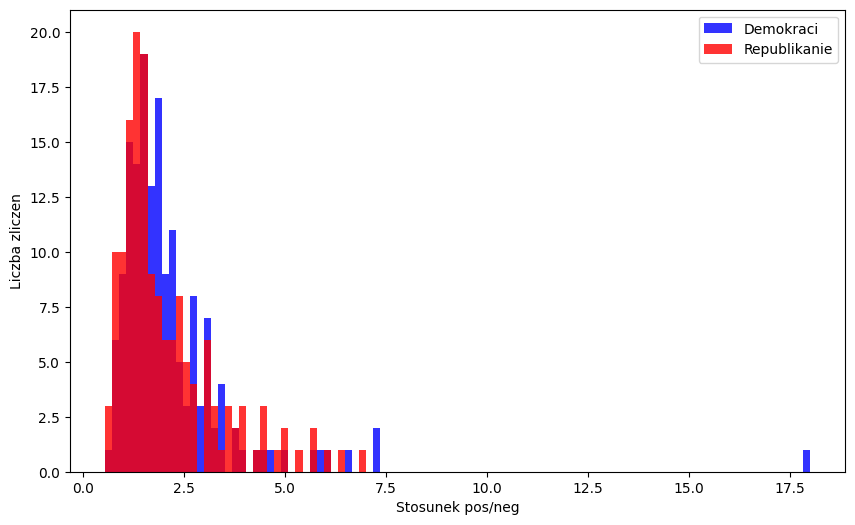

In [28]:
plot_hist(df_dem2['ratio'], df_rep2['ratio'], 'Stosunek pos/neg', 100)

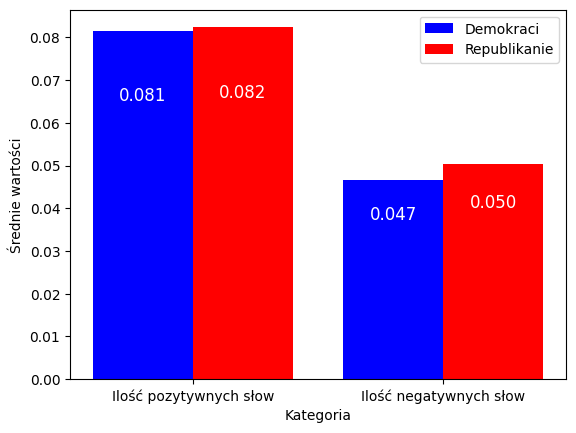

In [29]:
dem_pos_avg = df_dem2['pos'].mean()
dem_neg_avg = df_dem2['neg'].mean()
rep_pos_avg = df_rep2['pos'].mean()
rep_neg_avg = df_rep2['neg'].mean()


dem = [dem_pos_avg, dem_neg_avg]
rep = [rep_pos_avg, rep_neg_avg]
categories = ['Ilość pozytywnych słow', 'Ilość negatywnych słow']

plot_bar(categories, dem, rep, 'Średnie wartości', 'Kategoria')

# TextBlob

In [30]:
from textblob import TextBlob

In [31]:
def blob_sent(texts):
    sents = []
    for text in texts:
        blob = TextBlob(text)
        sentiment = blob.sentiment
        sents.append(sentiment)

    df = pd.DataFrame(sents)

    return df

In [32]:
dem_df3 = blob_sent(democrats_texts)
rep_df3 = blob_sent(republicans_texts)

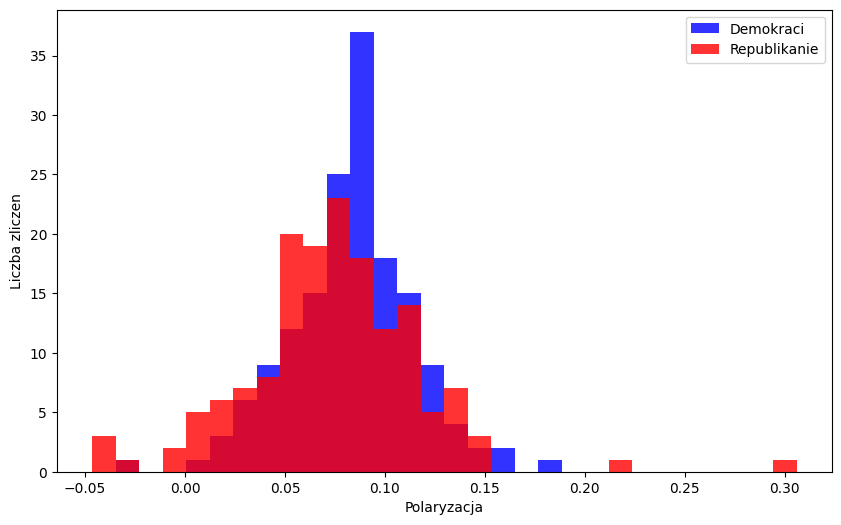

In [33]:
plot_hist(dem_df3['polarity'], rep_df3['polarity'], 'Polaryzacja', 30)

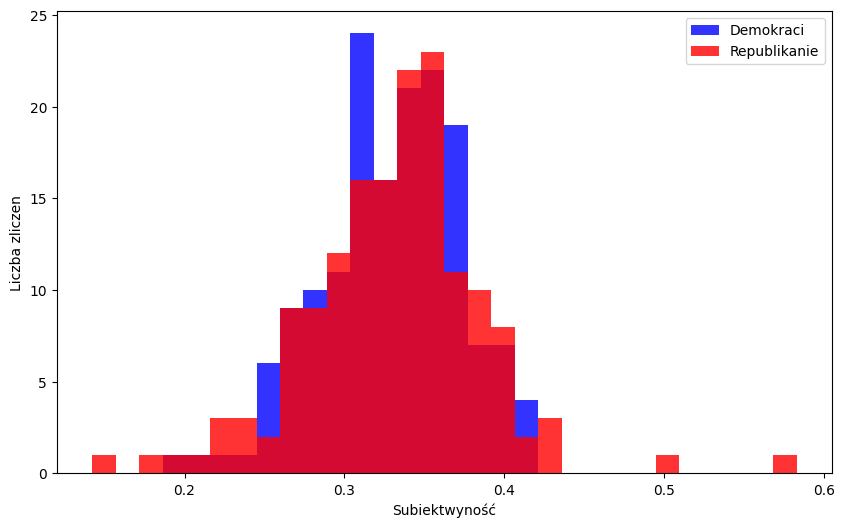

In [35]:
plot_hist(dem_df3['subjectivity'], rep_df3['subjectivity'], 'Subiektwyność', 30)

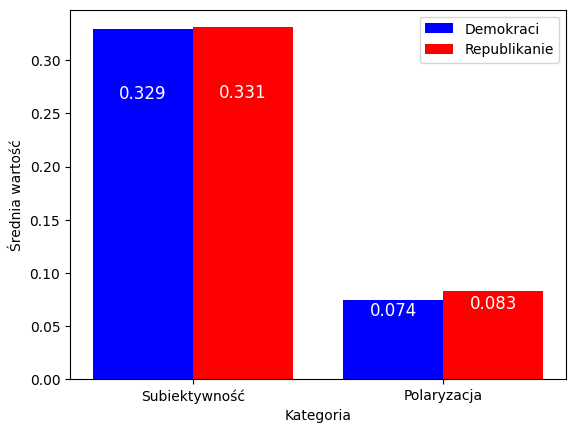

In [ ]:
sub_rep = rep_df3['subjectivity'].mean()
sub_dem = dem_df3['subjectivity'].mean()

pol_rep = rep_df3['polarity'].mean()
pol_dem = dem_df3['polarity'].mean()

dem = [sub_dem, pol_rep]
rep = [sub_rep, pol_dem]

categories = ['Subiektywność', 'Polaryzacja']

plot_bar(categories, dem, rep, 'Średnia wartość', 'Kategoria')